# Cohort analysis

### What is cohort analysis?
Say you own an online clothing store and you want to learn more about the behavior of your customers. One way you can do this is to define metrics that summarize and capture how customers engage with your store. Of the many metrics that you could define to summarize engagement, a common one is customer retention. Customer retention is derived by tracking how and when people first engage with a product compared to their subsequent engagement.

Keeping this metric in mind, we need to split your customers up into groups or cohorts. A cohort is a group of people who share something in common. In this case, we'll define a cohort as customers who have made their first purchase within the same month. This means that everyone who made an initial purchase in May belongs to the May cohort, everyone who made a first purchase in June belongs to the June cohort, and so on.

---
Dataset: [source](https://archive.ics.uci.edu/dataset/502/online+retail+ii)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import numpy as np
import calendar

In [2]:
df1 = pd.read_excel("data/online_retail_II.xlsx", sheet_name="Year 2009-2010", 
                    parse_dates=['InvoiceDate'], 
                    dtype={'Customer ID': str, 'Invoice': str})
df2 = pd.read_excel("data/online_retail_II.xlsx", sheet_name="Year 2010-2011",
                    parse_dates=['InvoiceDate'], 
                    dtype={'Customer ID': str, 'Invoice': str})
data = pd.concat([df1,df2])
data.rename(columns={
    "Invoice": "InvoiceNo", 
    "Customer ID": "CustomerID",
    "Price": "UnitPrice",
    }, inplace=True)
data.dropna(inplace=True)
data = data[data["Quantity"] > 0]
print(f"Shape of dataframe: {data.shape}")
data.sample(10)

Shape of dataframe: (805620, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
424981,573300,84927F,PSYCHEDELIC TILE HOOK,1,2011-10-28 16:10:00,0.39,16049,United Kingdom
408838,528581,21043,APRON MODERN VINTAGE COTTON,4,2010-10-22 13:27:00,5.95,18055,United Kingdom
464732,533295,22536,MAGIC DRAWING SLATE PURDEY,4,2010-11-16 16:08:00,0.42,15161,United Kingdom
416408,529157,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,6,2010-10-26 16:49:00,2.95,13969,United Kingdom
517599,580066,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2011-12-01 13:33:00,1.25,14309,United Kingdom
199422,554098,22895,SET OF 2 TEA TOWELS APPLE AND PEARS,1,2011-05-22 13:01:00,3.25,14769,United Kingdom
83832,497204,22083,PAPER CHAIN KIT RETRO SPOT,4,2010-02-07 11:52:00,2.95,15422,United Kingdom
213067,555518,22621,TRADITIONAL KNITTING NANCY,12,2011-06-05 10:58:00,1.65,14891,United Kingdom
150541,549448,21463,MIRRORED DISCO BALL,4,2011-04-08 14:07:00,5.95,13078,United Kingdom
457093,532746,22867,HAND WARMER BIRD DESIGN,12,2010-11-14 13:13:00,2.10,13384,United Kingdom


### Exploratory data analysis 
Calculating the number of orders per customer and the rate at which customers make more than a single purchase

In [3]:
# get the total number of orders
n_orders = data.groupby("CustomerID").nunique()

# count the customers who've made more than one order
more_than_one_order = int(
    np.sum(n_orders["InvoiceNo"] > 1) / data["CustomerID"].nunique() * 100
)

# count the customers who've made more than 2 orders
multiple_orders = int(
    np.sum(n_orders["InvoiceNo"] > 2) / data["CustomerID"].nunique() * 100
)

In [4]:
print(f"{more_than_one_order}% of customers ordered more than once and {multiple_orders}% have ordered more than twice.")

72% of customers ordered more than once and 56% have ordered more than twice.


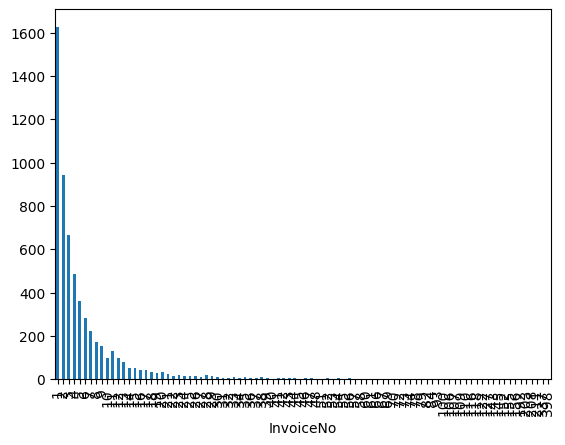

In [5]:
n_orders["InvoiceNo"].reset_index().groupby("InvoiceNo").size().plot(kind="bar");

### Creating cohorts


In [6]:
data = data[['CustomerID', 'InvoiceNo', 'InvoiceDate', 'UnitPrice']].drop_duplicates()

# Indicates the cohort that a customer belongs to based on initial purchase date (using the transform method will return all of the original indices with the applied transformation)
data['cohort'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Indicates the month that each customer has made a purchase
data['order_month'] = data['InvoiceDate'].dt.to_period('M')

cohorts = (
    data.groupby(["cohort", "order_month"])
    .agg(n_customers=("CustomerID", "nunique"), total_spent=("UnitPrice", "sum"))
    .reset_index(drop=False)
)
cohorts["period_number"] = (cohorts["order_month"] - cohorts["cohort"]).apply(
    attrgetter("n")
)

# Converts timestamps into calendar dates
cohorts["cohort"] = cohorts["cohort"].apply(
    lambda row: f"{calendar.month_abbr[int(str(row).split('-')[1])]} {str(row).split('-')[0]}"
)
cohorts["order_month"] = cohorts["order_month"].apply(
    lambda row: f"{calendar.month_abbr[int(str(row).split('-')[1])]} {str(row).split('-')[0]}"
)

retention_relative = cohorts.pivot_table(
    index="cohort", columns="period_number", values="n_customers", sort=False
)

# so that we preserve column order
columns = cohorts["order_month"].unique().tolist()
retention_absolute = cohorts.pivot_table(
    index="cohort", columns="order_month", values="n_customers", sort=False
)[columns]

retention_price = cohorts.pivot_table(
    index="cohort", columns="period_number", values="total_spent", sort=False
)

In [7]:
def matrix_of_retention(pivoted_table, matrix_type):

    metric = 'cohort size'
    cohort_size = pivoted_table.iloc[:,0].tolist()
    label = 'period since initial purchase'


    if matrix_type.lower() == 'relative':
        title = 'Monthly Cohorts: Relative User Retention'

    elif matrix_type.lower() == 'absolute':
        cohort_size = np.diag(pivoted_table)
        label = 'order month'
        title = 'Monthly Cohorts: Absolute User Retention'

    elif matrix_type.lower() == 'price':
        metric = "total spent"
        title = 'Monthly Cohorts: User Spending'
    else:
        raise ValueError("Invalid matrix type. Options are [relative, absolute, price]")
    
    
    retention_matrix = pivoted_table.divide(cohort_size, axis = 0)
    return retention_matrix, metric, label, title, cohort_size

def plot_retention(pivoted_table, matrix_type):

    retention_matrix, metric, label, title, cohort_size = matrix_of_retention(pivoted_table, matrix_type)

    # actual plot code
    with sns.axes_style("white"):
        if matrix_type != 'price':
            fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=False, gridspec_kw={'width_ratios': [1, 11]})
            
            # retention matrix
            sns.heatmap(retention_matrix, 
                        mask=retention_matrix.isnull(), 
                        annot=True, 
                        fmt='.0%', 
                        cmap='RdYlGn', 
                        ax=ax[1])
            ax[1].set_title(title, fontsize=16)
            ax[1].set(xlabel= label,
                    ylabel='cohort')

            # cohort size
            cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: f'{metric}'})
            white_cmap = mcolors.ListedColormap(['white'])
            sns.heatmap(cohort_size_df, 
                        annot=True, 
                        cbar=False,
                        yticklabels=False, 
                        fmt='g', 
                        cmap=white_cmap, 
                        ax=ax[0])
        else:
            fig = plt.figure(figsize=(12, 8))
            sns.heatmap(retention_matrix, 
                        mask=retention_matrix.isnull(), 
                        annot=True, 
                        fmt='.0%', 
                        cmap='RdYlGn')

        fig.tight_layout()

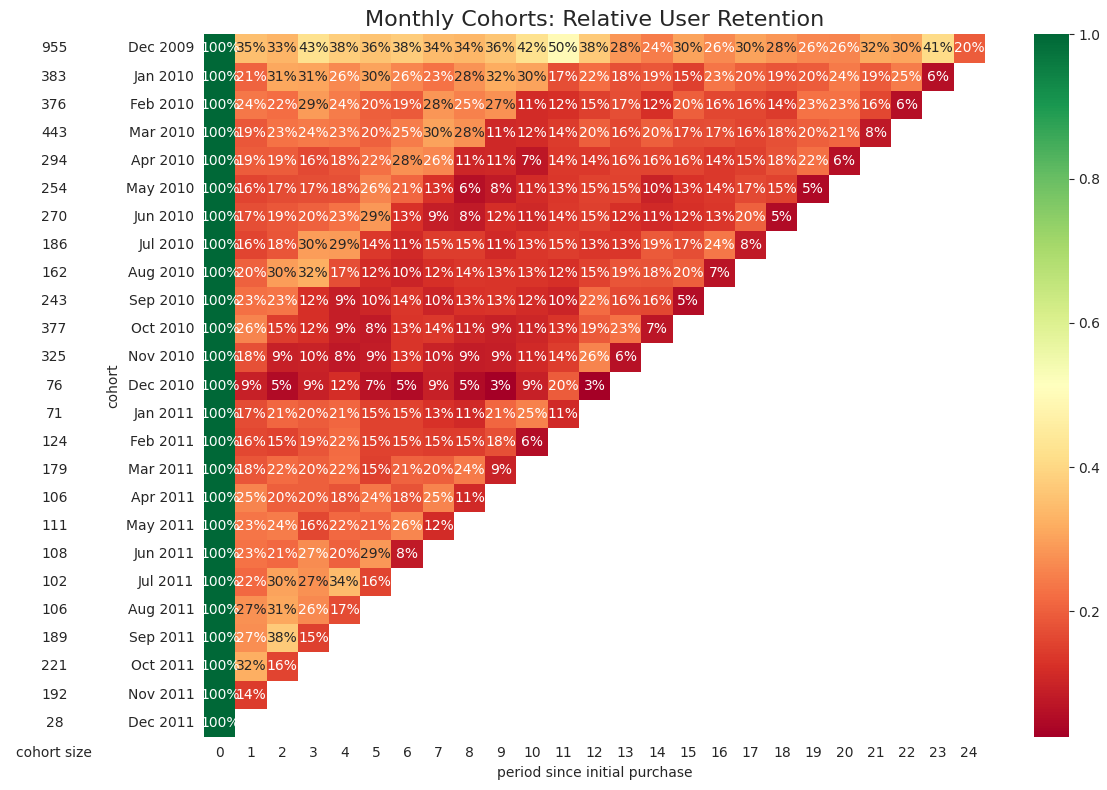

In [8]:
plot_retention(retention_relative, 'relative')

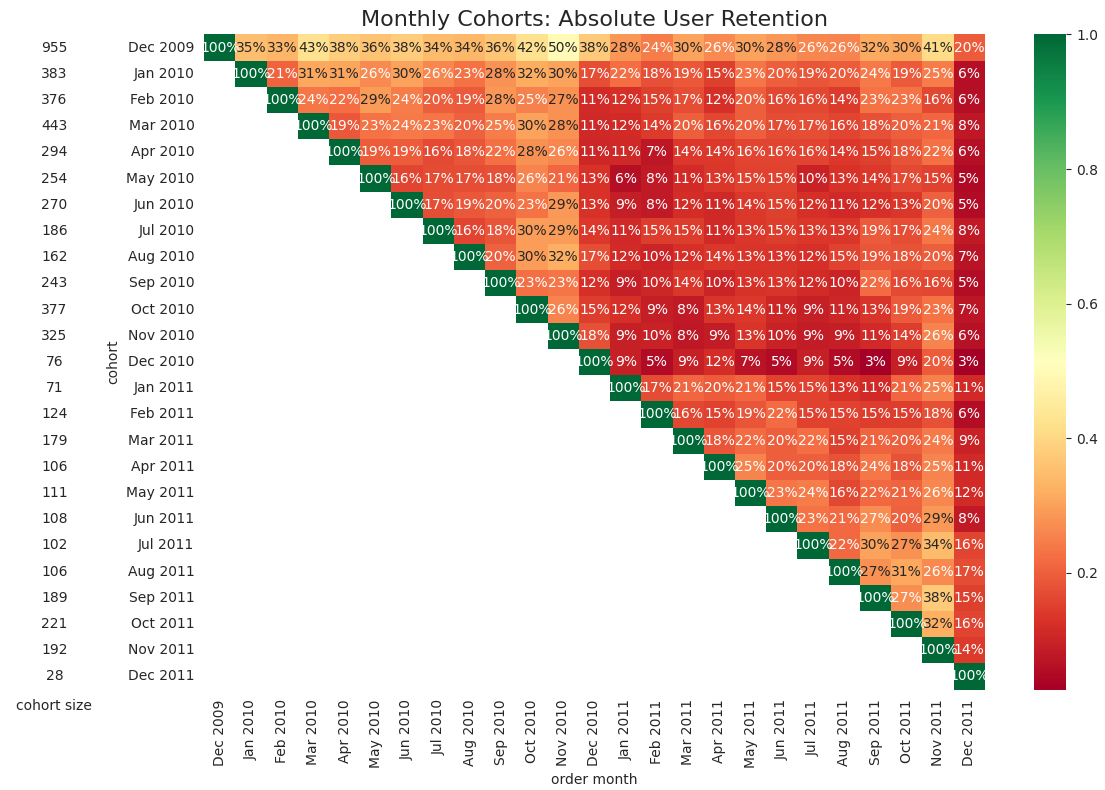

In [9]:
plot_retention(retention_absolute, 'absolute')

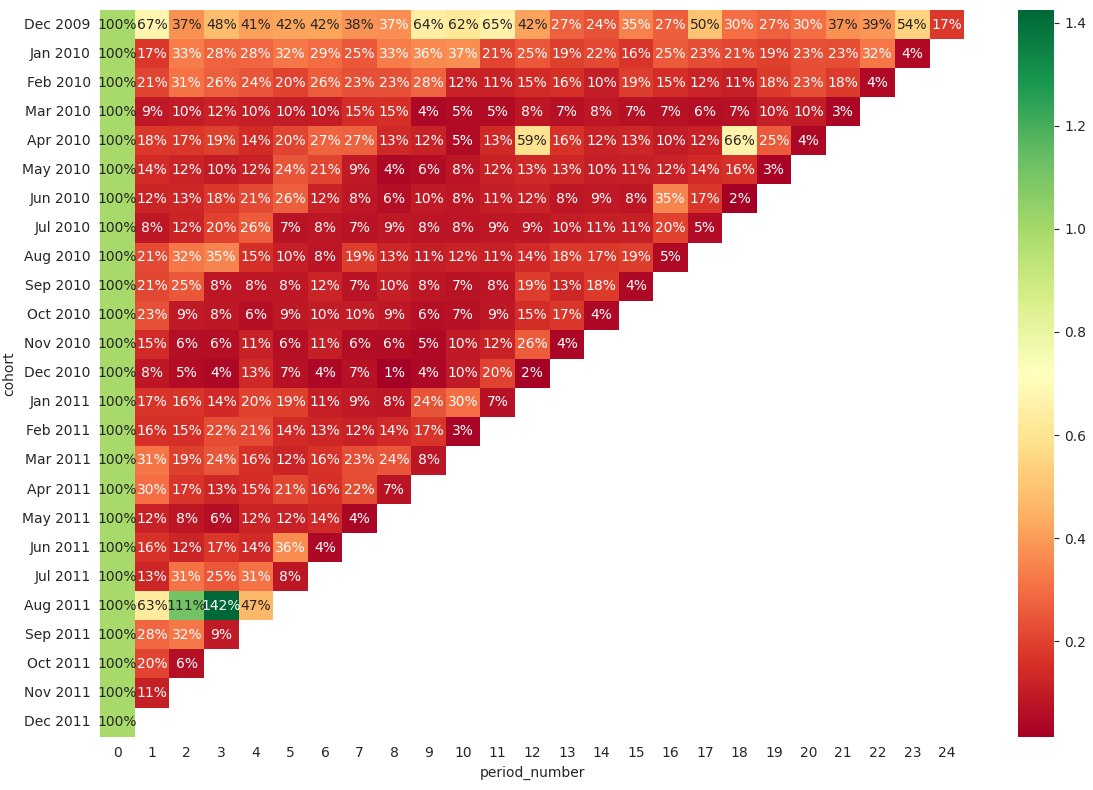

In [10]:
plot_retention(retention_price, 'price')